# Attention All in ONE

“注意力”在平时的生活中相信大家都深有体会，当你认真读某本书的时候，会感觉眼睛中只有书中正在读的文字，竖起耳朵去听一个很微弱的声音的时候，这个声音也仿佛放大了，能听的更清楚。深度学习中Attention机制非常类似生物的注意力。人们视觉在感知东西的时候一般不会是一个场景从到头看到尾每次全部都看，而往往是根据需求观察注意特定的一部分。而且当人们发现一个场景经常在某部分出现自己想观察的东西时，人们会进行学习在将来再出现类似场景时把注意力放到该部分上。

![](./asset/attention/visual1.jpg)

不同时刻，在做不同任务的时候，我们的注意力不是一成不变的。就输入下图，我们在做图片翻译到文字的任务时，翻译不同对象的时候，聚焦的图片位置是有区别。

![](./asset/attention/visual2.png)

基于以上的直觉，Attention可以用于，学习权重分布：

   + 这个加权可以是保留所有分量均做加权（即soft attention）；也可以是在分布中以某种采样策略选取部分分量（即hard attention），此时常用RL来做；
   + 这个加权可以作用在原图上，也可以作用在特征图上；
   + 这个加权可以在时间维度、空间维度、mapping维度以及feature维度。

   以seq2seq举例，传统的模型decoder输入的上下文c是一成不变的，但这显然不够合理，如果这是一个翻译模型，原文为“我喜欢食物”，当我翻译到"i like"时，我翻译下一个"food"时应该更关注的是"食物"，而不是别的。
   
![](./asset/attention/seq2seq1.png)

所以，我们在seq2seq解码过程中，在每一步可以利用Attention，对Encoder每一步的hidden state进行加权，获得不同的语义编码，获得更好的翻译效果。

![](./asset/attention/seq2seq2.png)

效果展示,横轴是输入的待翻译原文，纵轴是翻译结果，可以看到翻译到不同的英文单词时，对于原文的单词注意力差别是非常巨大的。

![](./asset/attention/seq2seq3.png)

同时，我们还可以利用Attention对多任务进行聚焦、解耦（通过attention mask），使得单一模型能够进行多项任务，且均达到比较良好的性能。多任务模型，可以通过Attention对feature进行权重再分配，聚焦各自关键特征。在图像分割论文***Fully Convolutional Network with Task Partitioning for Inshore Ship Detection in Optical Remote Sensing Images***中:

针对靠岸舰船，本文通过任务解耦的方法来处理。因为高层特征表达能力强，分类更准，但定位不准；底层低位准，但分类不准。为了应对这一问题，本文利用一个深层网络得到一个粗糙的分割结果图（船头/船尾、船身、海洋和陆地分别是一类）即Attention Map；利用一个浅层网络得到船头/船尾预测图，位置比较准，但是有很多虚景。**训练中，使用Attention Map对浅层网络的loss进行引导，只反传在粗的船头/船尾位置上的loss，其他地方的loss不反传。**相当于，**深层的网络能得到一个船头/船尾的大概位置，然后浅层网络只需要关注这些大概位置，然后预测出精细的位置，图像中的其他部分（如船身、海洋和陆地）都不关注，从而降低了学习的难度。** 

![](./asset/attention/visual3.png)

# Attention 发展历程

Attention机制最早是在视觉图像领域提出来的，应该是在九几年思想就提出来了，但是真正火起来应该算是2014年google mind团队的这篇论文《Recurrent Models of Visual Attention》，他们在RNN模型上使用了attention机制来进行图像分类。随后，Bahdanau等人在论文《Neural Machine Translation by Jointly Learning to Align and Translate》中，使用类似attention的机制在机器翻译任务上将翻译和对齐同时进行，他们的工作算是第一个将attention机制应用到NLP领域中。接着attention机制被广泛应用在基于RNN/CNN等神经网络模型的各种NLP任务中。2017年，google机器翻译团队发表的《Attention is all you need》中大量使用了自注意力（self-attention）机制来学习文本表示。自注意力机制也成为了大家的研究热点，结合预训练模型技术的发展，在NLP/CV/时间序列预测/推荐算法等多个领域均取得了巨大突破。。下图展示了attention研究进展的大概趋势：

![](./asset/attention/2_1.png)



# Attention 计算原理

---
$Attention(Q,K,V)=softmax(score({Q, K})V$

Google 2017年论文[Attention is All you need](w)中，为Attention做了一个抽象定义：

> An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.
>
> 注意力是将一个查询和键值对映射到输出的方法，Q、K、V均为向量，输出通过对V进行加权求和得到，权重就是Q、K相似度。
---

这是一个非常General的定义，我们举例说明一下QKV分别代表什么，在机器翻译中，Encoder 编码的信息是我们原始语义信息（V），Decoder的上一步输出的hidden state 定义的当前正在翻译的内容，是我们需要处理的问题（Q），此外我们还需要构造一个信息门牌（K），通过（Q）计算每个门牌的权重，用于给原始语义信息（V)做加权。

计算Attention Weighted Value有三个步骤：

1. 首先的到Q、K、V （在不同任务中，QKV需要用不同方式去构造）
2. 计算Q、K相似度
3. 将相似度进行Softmax处理，得到权重
4. 根据权重对V进行加权

![](./asset/attention/3_1.jpg)

而在整个过程中，最关键的是如何构造Q、K、V，然后是如何选择 `score`函数去计算相似度，这里先用几个案例讲解一下如何的到Q、K、V及score function。


# 文本分类&Attention

论文《Understanding Attention for Text Classification》中使用了一种比较简单且广泛使用的Q、K、V构造方式。

![](asset/attention/attention1.png)

输入文本长度为n，经过LSTM后得到每一步的hidden state 向量 $h_i$，这个向量同时看成K和V，查询向量Q使用一个可学习的模型参数向量W表示，并且使用dot product （点积运算）作为`score function`，这样就可以计算每一个K的score：

$$ score_i = \frac{h_i^{T} W}{\gamma} $$

其中，$\gamma$是一个比较大的常数，用于对点积结果做放缩，使得最后softmax后的权重更加平滑，一般情况下我们可以设置成K向量维度大小的根号 $\sqrt{d_K}$。

$$ weight = softmax(score) $$

其中每个分量按照softmax的到 $weight_i = \frac{e^{score_i}}{\sum{e^{score_j}}}$，这样我们就的到了Attention权重，只需要用其对V做加权求和就可以了。

将分类Attention权重可视化可以发现，重点的单词被给与了更高的权重，PAD特殊字符几乎0权重。

![](./asset/attention/4_1.png)
![](./asset/attention/4_2.png)

# Transformer with SelfAttention

《Attention is All You Need》是一个里程碑式的论文，提出了一种完全基于注意力机制的新模型结构 - Transformer，在NLP/CV/序列等大量领域均取得突破。

## Transformer基础结构

Transformer采用Encoder-Decoder架构，下图中左侧为encoder,右侧为decoder，Transformer encoder和decoder中使用3种网络结构：全连接层、多头自注意力层和LayerNorm层组成TransformerLayer，再对Transformer Layer堆叠N次。

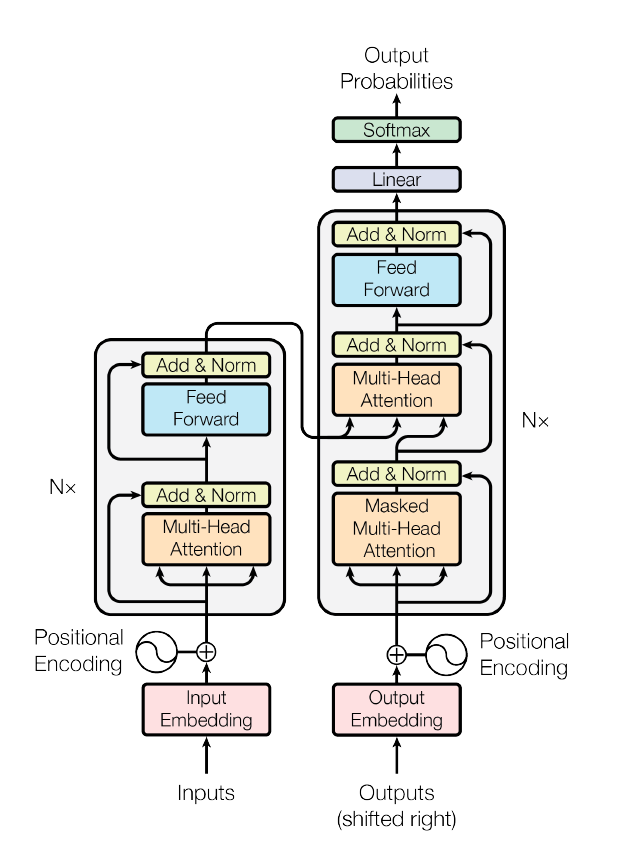


## LayerNorm

Batch Normalization 的处理对象是对一批样本， Layer Normalization 的处理对象是单个样本。Batch Normalization 是对这批样本的同一维度特征做归一化， Layer Normalization 是对这单个样本的所有维度特征做归一化。在Pytorch中，torch.nn.LayerNorm 实现了这个方法。

![](asset/attention/layernorm.png)

## 多头自注意力机制

重点是自注意力（Self Attention）。

![](asset/attention/selfattn1.png)

根据前面注意力机制的描述，我们只需要构造Q、K、V，可以通过点积计算相似度获得Attention 权重。而self-attention的特殊指出就在于， Q、K、V都来自输入本身！我们只需要构造3个线性映射$W_Q$、$W_K$、$W_V$，将原始输入映射成Q、K、V，就可以计算Attention了。

![](asset/attention/selfattn2.png)

多个自注意力机制输出结果合并，再经过一个线性映射$W_O$，就是多头自注意力输出结果了。

![](asset/attention/selfattn3.png)

## Transformer Layer

一个完整的Transformer Layer就是由全链接层、多头自注意力层及LayerNorm层构成的，具体结构如下图。

![](asset/attention/selfattn4.png)

需要注意的是，Transformer Layer 输入和输出的时序长度总是横等的，但是由于自注意力机制的存在，每个时间步都包含了其他时间步的所有信息，因此利用Transformer结构来做一些分类回归单步回归的问题时候，我们通常只会使用首个输出或者最后一步的输出结果，加入一个分类或者回归层来实现。PyTorch已经实现了Transformer Layer，我们来看看：

In [2]:
import torch
import torch.nn as nn

transformer = nn.TransformerEncoderLayer(
    d_model=36,  # 输入特征维度size
    nhead=6,   # 多头数量
    batch_first=True, # 类似LSTM/RNN的参数，是否设置地一个维度为batch size维度
)

In [3]:
# 模拟一个输入
x = torch.rand(4, 12, 36)

output = transformer(x)

In [4]:
print(output.shape)

torch.Size([4, 12, 36])


# 图像处理 & Attention

![](./asset/attention/visionattn.png)

论文《Attention mechanisms in computer vision: A survey》对典型的注意力机制在视觉领域中的应用做了一个总结。包含空间注意力，通道注意力，分支注意力，时序注意力（视频）等。这里我们以`CBAM`为例来讲解通道和空间注意力网络。

![](./asset/attention/CBAM1.png)

CBAM全称是Convolutional Block Attention Module, 是在ECCV2018上发表的注意力机制代表作之一。论文中，作者研究了网络架构中的注意力，注意力不仅要告诉我们重点关注哪里，还要提高关注点的表示。 目标是通过使用注意机制来增加表现力，关注重要特征并抑制不必要的特征。为了强调空间和通道这两个维度上的有意义特征，作者依次应用通道和空间注意模块，来分别在通道和空间维度上学习关注什么、在哪里关注。此外，通过了解要强调或抑制的信息也有助于网络内的信息流动。主要网络架构简单，一个是通道注意力模块，另一个是空间注意力模块，CBAM就是先后集成了通道注意力模块和空间注意力模块。

通道注意力机制按照下图进行实现，通过2个Shared MLP（采用卷积完成），输入每个通道特征图的avg/max pooling信息，输出每个通道的权重（经过sigmoid），进行信息的提取。需要注意的是，其中的bias需要人工设置为False。

![](./asset/attention/CBAM2.png)

```python

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, rotio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.sharedMLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False), nn.ReLU(),
            nn.Conv2d(in_planes // rotio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avgout = self.sharedMLP(self.avg_pool(x))
        maxout = self.sharedMLP(self.max_pool(x))
        return self.sigmoid(avgout + maxout)
```

空间注意力模块首先对原始特征图在通道维度进行max和avg，组成2通道输入，模型通过一个conv层输出所有像素点的权重值，即空间注意力。

![](./asset/attention/CBAM3.png)

```python
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3,7), "kernel size must be 3 or 7"
        padding = 3 if kernel_size == 7 else 1

        self.conv = nn.Conv2d(2,1,kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avgout = torch.mean(x, dim=1, keepdim=True)
        maxout, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avgout, maxout], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)
```

最后的使用一个类进行两个模块的集成，得到的通道注意力和空间注意力以后，使用广播机制对原有的feature map进行信息提炼，最终得到提炼后的feature map。以上代码以ResNet中的模块作为对象，实际运用可以单独将以下模块融合到网络中:

```python

class cbam(nn.Module):
 	def __init__(self, planes):
        super(cbam,self).__init__()
        self.ca = ChannelAttention(planes)# planes是feature map的通道个数
        self.sa = SpatialAttention()
    def forward(self, x):
        x = self.ca(x) * x  # 广播机制
        x = self.sa(x) * x  # 广播机制
```

# Ref

### Paper

1. [Hierarchical Attention Networks for Document Classification](https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf)
2. [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
3. [Neural Machine Translation by Jointly Learning to Align and Translate]()
4. [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention]()
5. [Fully Convolutional Network with Task Partitioning for Inshore Ship Detection in Optical Remote Sensing Images](ww)
6. [Effective Approaches to Attention-based Neural Machine Translation]()
7. [Vision Attention Survey](https://link.springer.com/content/pdf/10.1007/s41095-022-0271-y.pdf)
8. [Convolutional Block Attention Module](https://openaccess.thecvf.com/content_ECCV_2018/papers/Sanghyun_Woo_Convolutional_Block_Attention_ECCV_2018_paper.pdf)

### github

1. [pytorch-attention](https://github.com/thomlake/pytorch-attention)
2. [seq2seq](https://github.com/keon/seq2seq)
3. [PyTorch-Batch-Attention-Seq2seq](https://github.com/AuCson/PyTorch-Batch-Attention-Seq2seq)

### Blog

1. [一文读懂「Attention is All You Need」| 附代码实现 ](https://mp.weixin.qq.com/s?__biz=MzIwMTc4ODE0Mw==&mid=2247486960&idx=1&sn=1b4b9d7ec7a9f40fa8a9df6b6f53bbfb&chksm=96e9d270a19e5b668875392da1d1aaa28ffd0af17d44f7ee81c2754c78cc35edf2e35be2c6a1&scene=21#wechat_redirect)
2. [Attention Model（mechanism） 的 套路](https://blog.csdn.net/bvl10101111/article/details/78470716)
3. [【计算机视觉】深入理解Attention机制](https://blog.csdn.net/yideqianfenzhiyi/article/details/79422857)
4. [自然语言处理中的自注意力机制](https://www.cnblogs.com/robert-dlut/p/8638283.html])
5. [Encoder-Decoder模型和Attention模型](https://blog.csdn.net/u014595019/article/details/52826423)

